Reference for model stacking: https://www.kaggle.com/zhixinzhang/stacked-regressions-top-4-on-leaderboard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

#from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from sklearn.svm import SVR
#from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

from scipy.stats import uniform, randint

#import xgboost as xgb
import lightgbm as lgb
import datetime

Using TensorFlow backend.


In [44]:
def diagnostic_stats(ytrue, ypred):
    """
    https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression
    
    https://www.sciencedirect.com/topics/engineering/mean-bias-error
    """
    n = len(ytrue)

    # Check that the ytrue and ypred are equal length vector.
    assert n == len(ypred)
    
    # sum squared error
    sse = np.sum((ytrue - ypred)**2)
    
    # root mean square error
    rmse = np.sqrt(sse/n)

    # total sum of squares
    tss = np.sum((ytrue - np.mean(ytrue))**2)
    tst = np.sum((ypred - np.mean(ypred))**2)
    tstp = tst**0.5
    tssp = tss**0.5
    
    soorat = np.sum((ytrue-np.mean(ytrue))*(ypred-np.mean(ypred)))
    
    # Rsquare
    ##rsqr = 1 - sse/tss
    rsqr = (soorat/(tssp*tstp))**2

    # Mean biased error
    mbe = np.mean(ytrue - ypred)
    
    
    # IOAD
    num = np.sum((ytrue - ypred)**2)
    denom = np.abs(ytrue - ypred) + np.abs(ytrue + ypred)
    ioad = 1 - num/np.sum(denom**2)

    print("RMSE: %1.3f, R^2: %1.3f, MBE: %1.3f, IOAD: %1.3f"%(rmse, rsqr, mbe, ioad))
    
    return rmse, rsqr, mbe, ioad

In [45]:
df = pd.read_csv('rnn_data_prajwal.csv', parse_dates=['DateTime'], index_col='DateTime')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [47]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 01:00:00'), Timestamp('2014-01-01 00:00:00'))

In [48]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws']
yvar = 'Fc'

### Train-test splits
    1. Test: 60 days starting randomly picked date
    2. Train: Remaining data
        a. Layer 1 and Layer 2: 50:50 random split
        b. Layer 1 further divided into 1/m unique train sets, where m = number of unique models. 

In [49]:
# Test data set
# 60 days window starting from randomly picked day.
np.random.seed(41)
test_start_day = np.random.choice(df.index.date, 1)[0]
test_end_day = test_start_day + datetime.timedelta(days=60)
print('Test start date:', test_start_day)
print('Test end date:', test_end_day)

Test start date: 2013-03-21
Test end date: 2013-05-20


In [50]:
df_test = df.loc[test_start_day:test_end_day].copy()
df_train = pd.concat([df.loc[:test_start_day], df.loc[test_end_day:]]).copy()

# Scaling test frame
y_test_mean, y_test_std = df_test[yvar].mean(), df_test[yvar].std()
scaler_test = StandardScaler()
df_test[df_test.keys()] = scaler_test.fit_transform(df_test)

# Scaling train frame
y_train_mean, y_train_std = df_train[yvar].mean(), df_train[yvar].std()
scaler_train = StandardScaler()
df_train[df_train.keys()] = scaler_train.fit_transform(df_train)

In [51]:
print(df.loc[test_start_day:test_end_day].index.min(), '>', df.loc[:test_start_day].index.max())
print(df.loc[test_start_day:test_end_day].index.max(), '<',df.loc[test_end_day:].index.min())

assert df.loc[test_start_day:test_end_day].index.min() > df.loc[:test_start_day].index.max()
assert df.loc[test_start_day:test_end_day].index.max() < df.loc[test_end_day:].index.min()

2013-03-21 02:30:00 > 2013-03-20 21:00:00
2013-05-19 20:30:00 < 2013-05-20 06:00:00


In [52]:
X_test, y_test = df_test[Xvar], df_test[yvar]

In [10]:
#SEED, SEED2 = 40, 1
SEED, SEED2 = 20, 45
X_train_layer1, X_train_layer2, y_train_layer1, y_train_layer2 = train_test_split(df_train[Xvar], df_train[yvar], test_size=0.50, random_state=SEED, shuffle=True)

X_train1_layer1, X_rest1_layer1, y_train1_layer1, y_rest1_layer1 = train_test_split(X_train_layer1, y_train_layer1, test_size=5/6., random_state=SEED2, shuffle=True)
X_train2_layer1, X_rest2_layer1, y_train2_layer1, y_rest2_layer1 = train_test_split(X_rest1_layer1, y_rest1_layer1, test_size=4/5., random_state=SEED2, shuffle=True)
X_train3_layer1, X_rest3_layer1, y_train3_layer1, y_rest3_layer1 = train_test_split(X_rest2_layer1, y_rest2_layer1, test_size=3/4., random_state=SEED2, shuffle=True)
X_train4_layer1, X_rest4_layer1, y_train4_layer1, y_rest4_layer1 = train_test_split(X_rest3_layer1, y_rest3_layer1, test_size=2/3., random_state=SEED2, shuffle=True)
X_train5_layer1, X_train6_layer1,y_train5_layer1,y_train6_layer1 = train_test_split(X_rest4_layer1, y_rest4_layer1, test_size=1/2., random_state=SEED2, shuffle=True)

In [11]:
print('Full', df.shape[0], '-->', 'Test:', df_test.shape[0], 'Train:', df_train.shape[0], '-->',
      'Train layer1: ', X_train_layer2.shape[0], 'Train layer2: ', X_train_layer1.shape[0]),
print('Train layer1 model splits: ', X_train1_layer1.shape[0], X_train2_layer1.shape[0], X_train3_layer1.shape[0], 
      X_train4_layer1.shape[0], X_train5_layer1.shape[0], X_train6_layer1.shape[0])

Full 9015 --> Test: 1367 Train: 7648 --> Train layer1:  3824 Train layer2:  3824
Train layer1 model splits:  637 637 637 637 638 638


In [12]:
#Validation function
def rmsle_cv(model, X_train, y_train, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    clf = cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf)
    rmse= np.sqrt(-clf)
    return(rmse)


def rmsle_randomsearchcv(model, params, X_train, y_train, n_folds, random_state=0):
    clf = RandomizedSearchCV(model, params, random_state=random_state, cv=n_folds, return_train_score=True, 
                         scoring="neg_mean_squared_error")
    search = clf.fit(X_train, y_train)
    rmse= np.sqrt(-search.best_score_)
    return rmse, search


### Layer 1 training

In [13]:
N_FOLDS = 5

##### 1a. Gradient Boosting Regression

In [14]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.01, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# model_lgb = lgb.LGBMRegressor(**{'learning_rate': 0.05771297731744318,
#  'min_data_in_leaf': 6,
#  'n_estimators': 814,
#  'num_leaves': 3,
#  'objective': 'regression'})
# score_lgb = rmsle_cv(model_lgb, X_train1_layer1, y_train1_layer1, N_FOLDS)
# print("\nLightGBM score: {:.4f} (+/-{:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

# model_lgb.fit(X_train1_layer1, y_train1_layer1);

In [15]:
# Hyperparameter Optz
params = dict(num_leaves = randint(2,10), 
              n_estimators = randint(500,2000),
              learning_rate = uniform(1e-3, 1),
              min_data_in_leaf = randint(2,10),
              objective=['regression'])

model_lgb = lgb.LGBMRegressor()

score_lgb, model_lgb = rmsle_randomsearchcv(model_lgb, params, X_train1_layer1, y_train1_layer1, N_FOLDS)
print("\nLightGBM score: {:.4f} (+/-{:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



LightGBM score: 0.8364 (+/-0.0000)



##### 2. LASSO Regression

In [16]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =1e-4, random_state=1))
score = rmsle_cv(model_lasso, X_train2_layer1, y_train2_layer1, N_FOLDS)
print("\nLasso score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_lasso.fit(X_train2_layer1, y_train2_layer1);


Lasso score: 0.6859 (+/-0.0933)



##### 2b. Ridge regression

In [17]:
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.05, random_state=1))
score = rmsle_cv(model_ridge, X_train2_layer1, y_train2_layer1, N_FOLDS)
print("\nRidge score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_ridge.fit(X_train2_layer1, y_train2_layer1);


Ridge score: 0.6859 (+/-0.0933)



##### 3. Random Forest Estimator 

In [18]:
# model_rfe = RandomForestRegressor(n_estimators=500, criterion='mse', 
#                             max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=2)
# score = rmsle_cv(model_rfe, X_train3_layer1, y_train3_layer1, N_FOLDS)
# print("\n Random Forest score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
# model_rfe.fit(X_train3_layer1, y_train3_layer1);

In [19]:
# Hyperparameter Optz
params = dict(n_estimators = randint(400, 1000), criterion=['mse'], 
              max_depth=randint(3,25), min_samples_leaf=randint(2,15), 
              min_samples_split=randint(2,15))

model_rfe = RandomForestRegressor(random_state=1)

score, model_rfe = rmsle_randomsearchcv(model_rfe, params, X_train3_layer1, y_train3_layer1, N_FOLDS)
print("\n Random Forest score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Random Forest score: 0.6357 (+/-0.0000)



##### 4. SVM

In [20]:
# model_svm = SVR(kernel='rbf', degree=3, gamma='scale', tol=1e-3, C=1.0, epsilon=0.2)
# score = rmsle_cv(model_svm, X_train4_layer1, y_train4_layer1, N_FOLDS)
# print("\n Support Vector Reg: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
# model_svm.fit(X_train4_layer1, y_train4_layer1);

In [21]:
# Hyperparameter Optz
params = dict(kernel = ['rbf', 'poly', 'sigmoid'], 
              degree = randint(2,6),
              gamma = ['scale'],
              C = uniform(1, 100))

model_svm = SVR()

score, model_svm = rmsle_randomsearchcv(model_svm, params, X_train4_layer1, y_train4_layer1, N_FOLDS)
print("\n Support Vector score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_svm.best_params_

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Support Vector score: 0.5648 (+/-0.0000)



{'C': 30.753460654447228, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

##### 5. Gaussian Process

In [22]:
# kernel=None
# model_gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=2)
# score = rmsle_cv(model_gp, X_train5_layer1, y_train5_layer1, N_FOLDS)
# print("\n Gaussian Process Reg: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

# model_gp.fit(X_train5_layer1, y_train5_layer1);

In [23]:
# Hyperparameter Optz
params = dict(kernel = [None], 
              optimizer = ['fmin_l_bfgs_b', 'adam'],
              alpha = uniform(1e-10, 1))

model_gp = GaussianProcessRegressor()

score, model_gp = rmsle_randomsearchcv(model_gp, params, X_train5_layer1, y_train5_layer1, N_FOLDS)
print("\n GP score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_gp.best_params_


 GP score: 0.5713 (+/-0.0000)



/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.8121687288754932, 'kernel': None, 'optimizer': 'fmin_l_bfgs_b'}

##### 6. Deep Learning

In [24]:
# # define wider model
# def dl_model():
#     # Create model
#     model = Sequential()
#     model.add(Dense(15, input_dim=8, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(8, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(6, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
    
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#     return model

# model_dl = KerasRegressor(dl_model, epochs=100, batch_size=500, verbose=0)
# score = rmsle_cv(model_dl, X_train6_layer1, y_train6_layer1, N_FOLDS)
# print("\n Deep learning: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

# model_dl.fit(X_train6_layer1, y_train6_layer1);

##### 6b. Neural Network

In [25]:
# Hyperparameter Optz
params = dict(hidden_layer_sizes = randint(5,200), 
              activation = ['relu', 'logistic'], 
              solver = ['adam', 'sgd', 'lbfgs'],
              alpha = uniform(1e-5, 1e-2),
              learning_rate_init = uniform(1e-4, 0.1),
              learning_rate = ['constant', 'adaptive'], 
              )

model_ann = MLPRegressor(random_state=12, max_iter=1000)

score, model_ann = rmsle_randomsearchcv(model_ann, params, X_train6_layer1, y_train6_layer1, N_FOLDS)
print("\n ANN/MLPRegressor score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_ann.best_params_

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 ANN/MLPRegressor score: 0.7434 (+/-0.0000)



{'activation': 'logistic',
 'alpha': 0.009035984755294046,
 'hidden_layer_sizes': 47,
 'learning_rate': 'constant',
 'learning_rate_init': 0.061406345788413245,
 'solver': 'sgd'}

#### Comparing metrics for all single cases on train layer 1 data

In [26]:
models = dict(LGBM=[model_lgb, X_train1_layer1, y_train1_layer1, 'LGBM'], 
              LASSO=[model_lasso, X_train2_layer1, y_train2_layer1, 'LASSO'], 
              RFE=[model_rfe, X_train3_layer1, y_train3_layer1, 'RFE'], 
              SVM=[model_svm, X_train4_layer1, y_train4_layer1, 'SVM'], 
              GP=[model_gp, X_train5_layer1, y_train5_layer1, 'GP'], 
              ANN=[model_ann, X_train6_layer1, y_train6_layer1, 'ANN'])

In [27]:
for key, val in models.items():
    ypred = val[0].predict(val[1])*y_train_std + y_train_mean
    
    ytrue = val[2]*y_train_std + y_train_mean
    
    print(val[3])
    diagnostic_stats(ytrue, ypred)

LGBM
RMSE: 1.951, R^2: 0.855, MBE: 0.000, IOAD: 0.969
LASSO
RMSE: 3.227, R^2: 0.520, MBE: 0.000, IOAD: 0.910
RFE
RMSE: 2.216, R^2: 0.781, MBE: -0.003, IOAD: 0.957
SVM
RMSE: 1.950, R^2: 0.805, MBE: 0.112, IOAD: 0.962
GP
RMSE: 1.983, R^2: 0.799, MBE: 0.004, IOAD: 0.960
ANN
RMSE: 3.322, R^2: 0.537, MBE: -0.305, IOAD: 0.908


##### Predictions using layer 1 models for layer 2 data

In [28]:
y_pred1_layer2 = model_lgb.predict(X_train_layer2)
y_pred2_layer2 = model_lasso.predict(X_train_layer2)
y_pred3_layer2 = model_rfe.predict(X_train_layer2)
y_pred4_layer2 = model_svm.predict(X_train_layer2)
y_pred5_layer2 = model_gp.predict(X_train_layer2)
y_pred6_layer2 = model_ann.predict(X_train_layer2)


y_pred1_test = model_lgb.predict(X_test)
y_pred2_test = model_lasso.predict(X_test)
y_pred3_test = model_rfe.predict(X_test)
y_pred4_test = model_svm.predict(X_test)
y_pred5_test = model_gp.predict(X_test)
y_pred6_test = model_ann.predict(X_test)

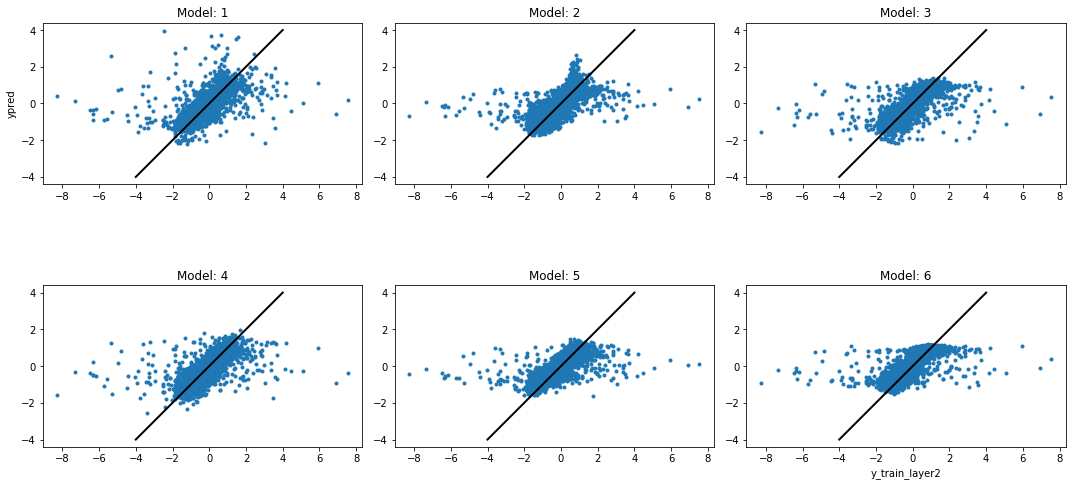

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax = ax.flatten()
for i, preds in enumerate([y_pred1_layer2, y_pred2_layer2, 
                           y_pred3_layer2, y_pred4_layer2, 
                           y_pred5_layer2, y_pred6_layer2]):
    ax[i].plot(y_train_layer2, preds, '.')
    ax[i].set_title('Model: {0}'.format(i+1))
    ax[i].plot([-4,4],
               [-4,4], 'k', lw=2)
    ax[i].set_aspect('equal')
ax[0].set_ylabel('ypred')
plt.xlabel('y_train_layer2')
plt.tight_layout()

### Layer 2 training

In [30]:
# Train data
Yfeatures_train_layer2 = pd.DataFrame(np.array([y_pred1_layer2.squeeze(), y_pred2_layer2.squeeze(),
                                                y_pred3_layer2.squeeze(), y_pred4_layer2.squeeze(),
                                                y_pred5_layer2.squeeze(), y_pred6_layer2.squeeze()]).T)
Yfeatures_train_layer2.shape, y_train_layer2.shape

((3824, 6), (3824,))

##### ENSEMBLE: Training on layer 2 (Yfeatures(Layer1 Model(X)), y_train) 

In [31]:
Yfeatures_train_layer2.shape

(3824, 6)

In [32]:
# Hyperparameter Optz
# params = dict(n_estimators = randint(400, 1000), criterion=['mse'], 
#               max_depth=randint(3,25), min_samples_leaf=randint(2,15), 
#               min_samples_split=randint(2,15))

# score, model_layer2_rfe_ensemble = rmsle_randomsearchcv(RandomForestRegressor(random_state=1), params, 
#                                                         Yfeatures_train_layer2, y_train_layer2, N_FOLDS)
# print("\n Random Forest score ensemble: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


# Hyperparameter Optz
params = dict(num_leaves = randint(2,10), 
              n_estimators = randint(500,2000),
              learning_rate = uniform(1e-3, 1),
              min_data_in_leaf = randint(2,10),
              objective=['regression'])

model_layer2_lgb_ensemble = lgb.LGBMRegressor()

score, model_layer2_lgb_ensemble = rmsle_randomsearchcv(model_layer2_lgb_ensemble, params, 
                                                        Yfeatures_train_layer2, y_train_layer2, N_FOLDS)
print("\nLightGBM score ensemble: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


LightGBM score ensemble: 0.6941 (+/-0.0000)



##### SINGLE: Training directly on layer 2 (X_train, y_train)

In [33]:
# Hyperparameter Optz
# params = dict(n_estimators = randint(400, 5000), criterion=['mse'], 
#               max_depth=randint(3,25), min_samples_leaf=randint(2,15), 
#               min_samples_split=randint(2,15))

# model_layer2_rfe_single = RandomForestRegressor(random_state=1)

# score, model_layer2_rfe_single = rmsle_randomsearchcv(model_layer2_rfe_single, params, 
#                                                X_train_layer2, y_train_layer2, N_FOLDS, random_state=3)
# print("\n Random Forest score single: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


# Hyperparameter Optz
params = dict(num_leaves = randint(2,10), 
              n_estimators = randint(500,2000),
              learning_rate = uniform(1e-3, 1),
              min_data_in_leaf = randint(2,10),
              objective=['regression'])

model_layer2_lgb_single = lgb.LGBMRegressor()

score, model_layer2_lgb_single = rmsle_randomsearchcv(model_layer2_lgb_single, params, 
                                                        X_train_layer2, y_train_layer2, N_FOLDS)
print("\nLightGBM score single: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


LightGBM score single: 0.6878 (+/-0.0000)



## Test


In [34]:
Yfeatures_test = pd.DataFrame(np.array([y_pred1_test.squeeze(), y_pred2_test.squeeze(),
                                        y_pred3_test.squeeze(), y_pred4_test.squeeze(),
                                        y_pred5_test.squeeze(), y_pred6_test.squeeze()]).T)
print(Yfeatures_test.shape, y_test.shape)

(1367, 6) (1367,)


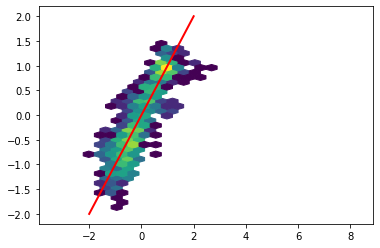

In [35]:
plt.hexbin(y_test, model_layer2_lgb_ensemble.predict(Yfeatures_test), mincnt=2, gridsize=30, bins='log')
plt.plot([-2,2], [-2,2], 'r', lw=2)

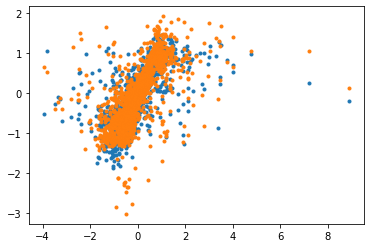

In [36]:
plt.plot(y_test, model_layer2_lgb_ensemble.predict(Yfeatures_test),'.')
plt.plot(y_test, model_layer2_lgb_single.predict(X_test),'.')

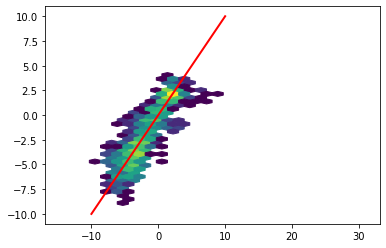

In [37]:
plt.hexbin(y_test*y_test_std + y_test_mean, 
           model_layer2_lgb_ensemble.predict(Yfeatures_test)*y_test_std + y_test_mean, mincnt=2, 
           gridsize=30, bins='log')
plt.plot([-10,10], [-10,10], 'r', lw=2)

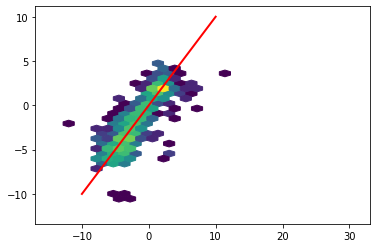

In [38]:
plt.hexbin(y_test*y_test_std + y_test_mean, model_layer2_lgb_single.predict(X_test)*y_test_std + y_test_mean, 
           mincnt=2, 
           gridsize=30, bins='log')
plt.plot([-10,10], [-10,10], 'r', lw=2)

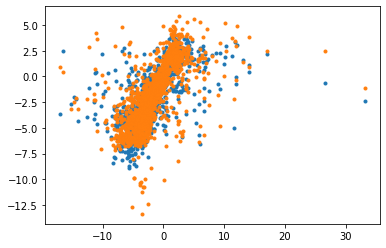

In [39]:
plt.plot(y_test*y_test_std + y_test_mean, model_layer2_lgb_ensemble.predict(Yfeatures_test)*y_test_std + y_test_mean,'.')
plt.plot(y_test*y_test_std + y_test_mean, model_layer2_lgb_single.predict(X_test)*y_test_std + y_test_mean,'.')

In [40]:
print('Ensemble')
y_test_pred_ensemble = model_layer2_lgb_ensemble.predict(Yfeatures_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_ensemble*y_test_std + y_test_mean);

Ensemble
RMSE: 2.954, R^2: 0.442, MBE: 0.196, IOAD: 0.900


In [41]:
print('Singe Model')
y_test_pred_single = model_layer2_lgb_single.predict(X_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_single*y_test_std + y_test_mean);

Singe Model
RMSE: 3.091, R^2: 0.404, MBE: 0.140, IOAD: 0.894


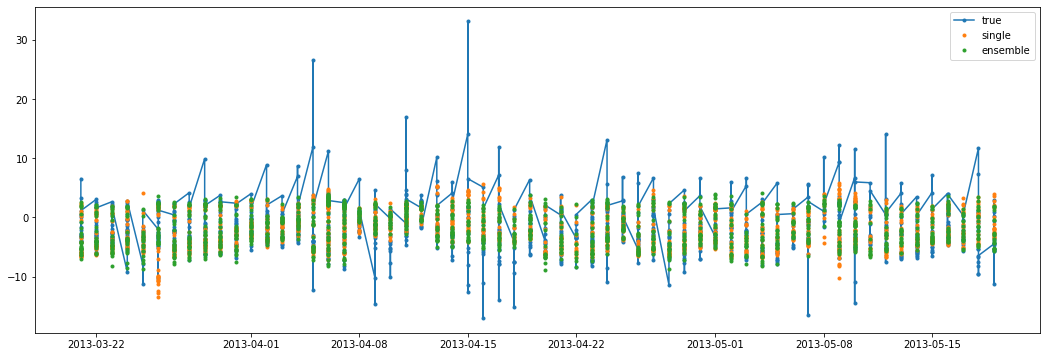

In [42]:
plt.figure(figsize=(18,6))
plt.plot(df_test.index.date, df_test[yvar]*y_test_std + y_test_mean, '.-', label='true')
plt.plot(df_test.index.date, y_test_pred_single*y_test_std + y_test_mean, '.', label='single')
plt.plot(df_test.index.date, y_test_pred_ensemble*y_test_std + y_test_mean, '.', label='ensemble')
plt.legend()

(-5, 5)

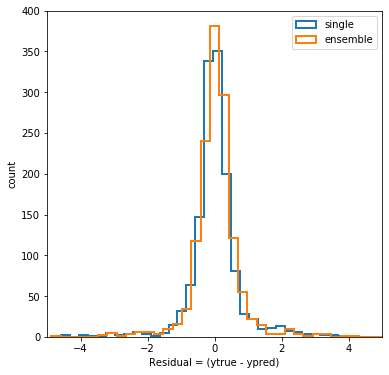

In [43]:
plt.figure(figsize=(6,6))
plt.hist(df_test[yvar] - y_test_pred_single, histtype='step', lw=2, label='single', bins=50)
plt.hist(df_test[yvar] - y_test_pred_ensemble, histtype='step', lw=2, label='ensemble', bins=50)
plt.xlabel('Residual = (ytrue - ypred)')
plt.ylabel('count')
plt.legend()
plt.xlim(-5,5)